# Unsupervised Learning with Autoencoder

### Imports

In [27]:
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.pytorch.layers import PyTorchLayer, DenseLayer
from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor
from lincoln.pytorch.utils import assert_dim, permute_data
print("all libs imported")

all libs imported


In [28]:
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])
print("Data, transforms, and DataLoader imported")

Data, transforms, and DataLoader imported


### Set Constants 

In [29]:
SEED = 20190325
# NUM_THREADS = 16 # for interop parallelism 
NUM_WORKERS = 16 # for torch.DataLoader 
USE_GPU = False
DEFAULT_DTYPE = torch.FloatTensor
print("SEED:", SEED)
# print("NUM_THREADS:", NUM_THREADS)
print("NUM_WORKERS:", NUM_WORKERS)
print("USE_GPU:", USE_GPU)
print("DEFAULT_DTYPE", DEFAULT_DTYPE)

SEED: 20190325
NUM_WORKERS: 16
USE_GPU: False
DEFAULT_DTYPE <class 'torch.FloatTensor'>


### Prime Torch with Seed

In [30]:
torch.manual_seed(SEED);
print("seed: ", SEED)

seed:  20190325


### Enable GPU

In [31]:
if USE_GPU:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        print("gpu not available")
        import sys
        sys.exit()
else:
    device = torch.device("cpu")
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Set default Tensor type (cpu or cuda)
Not sure if we really want to do this. It seems non-canonical. 
No, we don't want to do this because it doesn't play well with multiprocessing.
https://discuss.pytorch.org/t/is-there-anything-wrong-with-setting-default-tensor-type-to-cuda/27949/3

In [32]:
# if USE_GPU:
#     # set default Tensor type (cpu or cuda)
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
if DEFAULT_DTYPE:
    torch.set_default_tensor_type(DEFAULT_DTYPE)
print("default Tensor type:", torch.tensor([3., 3.]).dtype)

default Tensor type: torch.float32


### Set num threads

In [33]:
# set num_threads
# torch.set_num_threads(NUM_THREADS)
print("num threads set: ", torch.get_num_threads())

num threads set:  4


### Enable autoreloading of modules

In [34]:
# autoreload reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
print("modules autorelading enabled")
# !jupyter nbextension list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
modules autorelading enabled


### Define ConvLayer Class

In [35]:
class ConvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size,
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)

        return x

## `DeconvLayer`

In [36]:
class DeconvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, filter_size, 
                                       padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.deconv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

## `Autoencoder`

In [37]:
class Autoencoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        self.dense2 = DenseLayer(hidden_dim, 7 * 28 * 28, activation=nn.Tanh())
        
        self.conv3 = ConvLayer(7, 14, 5, activation=nn.Tanh()) 
        self.conv4 = ConvLayer(14, 1, 5, activation=nn.Tanh())         

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)
#         import pdb; pdb.set_trace()
        encoding = self.dense1(x)
        
        x = self.dense2(encoding)
        
        x = x.view(-1, 7, 28, 28)
        
        x = self.conv3(x)
        x = self.conv4(x)

        return x, encoding
    

### Instantiate dataset, and optionally move to GPU

In [38]:
# https://pytorch.org/docs/stable/data.html
train_dataset = MNIST(root='../mnist_data/',
                      train=True,
                      download=True,
                      transform=img_transforms)

test_dataset = MNIST(root='../mnist_data/',
                     train=False,
                     download=True,
                     transform=img_transforms)

# train_dataset = train_dataset.to(device)
# test_dataset = test_dataset.to(device)
if USE_GPU:
    # train_dataset.data = train_dataset.data.to(device)
    # test_dataset.data = test_dataset.data.to(device)
    train_dataset.targets = train_dataset.targets.to(device)
    test_dataset.targets = test_dataset.targets.to(device)

## Preprocess data

In [39]:
mnist_train = ((train_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_test = ((test_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081

In [40]:
mnist_train.min(), mnist_train.max(), mnist_test.min(), mnist_test.max()

# move to GPU
mnist_train = mnist_train.to(device)
mnist_test = mnist_test.to(device)

In [41]:
X_train = mnist_train
X_test = mnist_test

In [42]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [43]:
model = Autoencoder()

In [44]:
model = Autoencoder(hidden_dim=28)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model, optimizer, criterion, device=device)

import time
start = time.time()
trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=1,
            batch_size=60)
print("time: ", time.time() - start, " seconds")

The loss after 1 epochs was 0.06897222250699997
time:  266.1293845176697  seconds


* cpu: 266.1293845176697  seconds 
* gpu: 4.414565086364746  seconds

In [45]:
reconstructed_images, image_representations = model(X_test_auto)

In [46]:
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [47]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

In [48]:
np.random.seed(20190504)
a = np.random.randint(0, 10000)

In [49]:
X_test[a].shape

torch.Size([1, 28, 28])

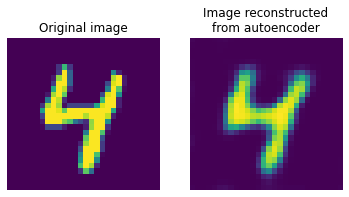

In [50]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[a].cpu())
display_image(axarr[1], reconstructed_images[a].cpu())

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

# f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")

# TSNE on the results

In [51]:
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2, random_state=20190405).fit_transform(image_representations.cpu().detach().numpy())

## TSNE viz

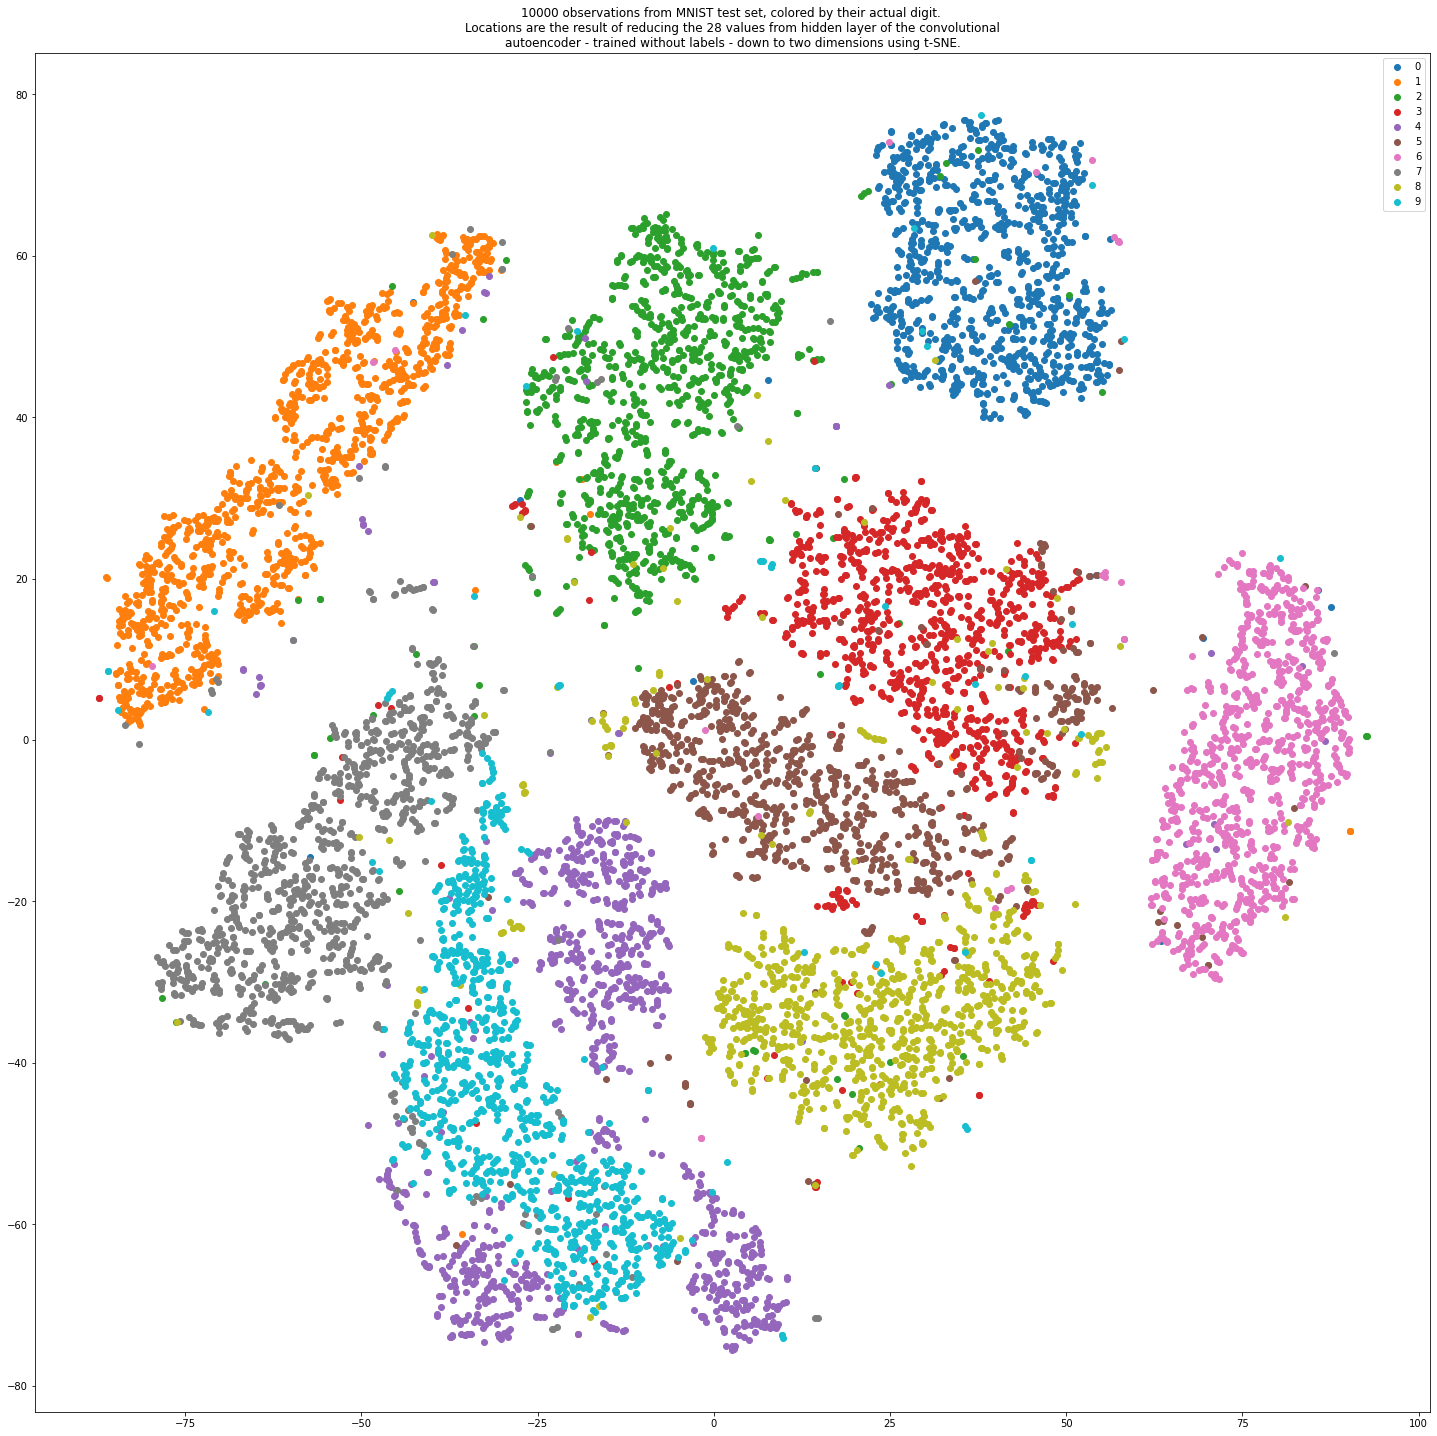

In [52]:
test_dataset.targets = test_dataset.targets.to('cpu')
import pandas as pd
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0],
              'tsne_dim_2': tsne_result[:,1],
              'category': test_dataset.targets})
groups = tsne_df.groupby('category')

# Plot
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('''10000 observations from MNIST test set, colored by their actual digit. 
Locations are the result of reducing the 28 values from hidden layer of the convolutional
autoencoder - trained without labels - down to two dimensions using t-SNE.''')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='o', label=name)
ax.legend();
# fig.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/00_tsne.png")
